# New section

In [ ]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

from tensorflow.keras.utils import to_categorical

from tensorflow.keras import Model

import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from keras.metrics import MeanIoU
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.layers import *
from tensorflow import keras



In [ ]:
tf.__version__

'2.12.0'

In [ ]:
!pip3 install -U segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 6.8 MB/s eta 0:00:00


In [ ]:
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm

#import segmentation_models_pytorch as sm

from tensorflow.keras.initializers import glorot_normal, he_normal
#kinit = 'glorot_normal'
kinit = 'he_normal'

""" Seeding """
seed_value= 12321

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)

# 5. For layers that introduce randomness like dropout, make sure to set seed values
#model.add(Dropout(0.25, seed=seed_value))

#6 Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)



"""os.environ["TF_NUM_INTRAOP_THREADS"] = "1"
os.environ["TF_NUM_INTEROP_THREADS"] = "1"
"""

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


'os.environ["TF_NUM_INTRAOP_THREADS"] = "1"\nos.environ["TF_NUM_INTEROP_THREADS"] = "1"\n'

In [ ]:
#Load Training Dataset
# Change the current working directory (Current directory should be of train dataset)

from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/Minor project/Data set_mash/

Mounted at /content/drive/
/content/drive/MyDrive/Minor project/Data set_mash


In [ ]:
cd /content/drive/MyDrive/Minor project/Data set_mash

/content/drive/MyDrive/Minor project/Data set_mash


In [ ]:
# Load Data

train_images = np.load('train_images_morpho.npy')
train_masks = np.load('train_masks_morpho.npy')
#train_mask1 =np.array(train_masks)

val_images = np.load('val_images_morpho.npy')
val_masks = np.load('val_masks_morpho.npy')

test_images = np.load('test_images_morpho.npy')
test_masks = np.load('test_masks_morpho.npy')

print(train_images.shape)
print(train_masks.shape)


print(val_images.shape)
print(val_masks.shape)

print(test_images.shape)
print(test_masks.shape)

(2750, 256, 256, 3)
(2750, 256, 256, 1)
(100, 256, 256, 3)
(100, 256, 256, 1)
(250, 256, 256, 3)
(250, 256, 256, 1)


In [ ]:
train_images.min()

0.0

In [ ]:
train_masks.max()

1.0

In [ ]:
train_masks[0,0:3,0:3,0]

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32)

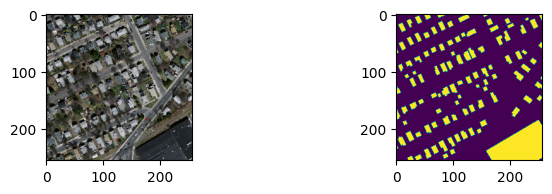

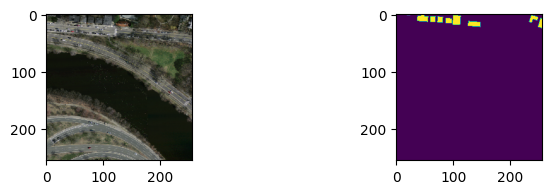

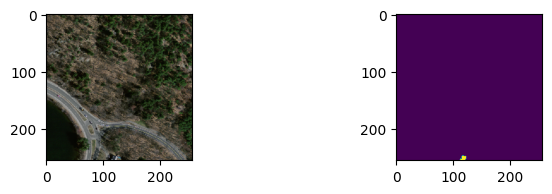

In [ ]:
#Sanity check, view few images
import random

for i in range(3):

    image_number = random.randint(0, len(train_images)-1)

    plt.subplot(131)
    plt.imshow(train_images[image_number])

    plt.subplot(133)
    plt.imshow(train_masks[image_number])
    plt.show()

In [ ]:
n_classes = 2
#assert np.all(np.isin(train_masks, np.arange(n_classes))), f"train_masks contains invalid values: {train_masks}"


# conver labels into ine-hot encoding

#n_classes = 2

#train_masks_cat = to_categorical(train_masks, num_classes=n_classes)
train_masks_cat = to_categorical(train_masks, num_classes=n_classes)
val_masks_cat = to_categorical(val_masks, num_classes=n_classes)
test_masks_cat = to_categorical(test_masks, num_classes=n_classes)

print(train_masks_cat.shape)
print(val_masks_cat.shape)
print(test_masks_cat.shape)

(2750, 256, 256, 2)
(100, 256, 256, 2)
(250, 256, 256, 2)


In [ ]:
#UNet Model
# import tensorflow as tf
# from tensorflow.keras import models, layers, regularizers
# from tensorflow.keras import backend as K
# from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda
# from tensorflow.keras import backend as K
# from tensorflow.keras.activations import sigmoid

def conv_block(x, filter_size, size, dropout, batch_norm=False):

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same", kernel_initializer=kinit)(x)

    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same", kernel_initializer=kinit)(conv)

    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv

In [ ]:
'''
Useful blocks to build Unet
conv - BN - Activation - conv - BN - Activation - Dropout (if enabled)
'''




def UNet(input_shape, NUM_CLASSES=2, dropout_rate=0.0, batch_norm=True):
    '''
    UNet,

    '''
    # network structure
    FILTER_NUM = 32 # number of filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters


    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers

    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, conv_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7

    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, conv_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8

    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, conv_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9

    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, conv_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers

    conv_final = layers.Conv2D(2, kernel_size=(1,1), kernel_initializer=kinit)(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('softmax')(conv_final)  #If 1 neuron at the output

    # Model
    model = models.Model(inputs, conv_final, name="UNet")

    return model
n_classes = 2 #1 if sigmoid and 2 if softmax

input_shape_1 = (train_images.shape[1], train_images.shape[2], train_images.shape[3])

model = UNet(input_shape_1, NUM_CLASSES=n_classes, dropout_rate=0.0, batch_norm=True)
model.summary()

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                              

In [ ]:



#from keras.utils.vis_utils import plot_model
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#loss = sm.losses.CategoricalCELoss()
#loss = sm.losses.JaccardLoss()
loss = sm.losses.DiceLoss()
#loss = sm.losses.CategoricalFocalLoss()

model.compile(optimizer='adam', loss=loss, metrics=[sm.metrics.iou_score])

#Early stopping
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, verbose=1, mode='min',
          restore_best_weights=True)

history = model.fit(train_images, train_masks_cat,
                    batch_size = 2,
                    verbose=1,
                    epochs=50,
                    validation_data=(val_images, val_masks_cat),
                    callbacks=[monitor],
                    shuffle=False)

#Save Model


model.save_weights('UNet_DL_BS8_10.h5')
#print('UNet_Without_Canny_Morpho_Softmax_DL_BS8')

Epoch 1/50
1375/1375 [==============================] - 117s 63ms/step - loss: 0.3357 - iou_score: 0.5473 - val_loss: 0.4872 - val_iou_score: 0.3868
Epoch 2/50
1375/1375 [==============================] - 86s 62ms/step - loss: 0.2489 - iou_score: 0.6512 - val_loss: 0.4263 - val_iou_score: 0.4476
Epoch 3/50
1375/1375 [==============================] - 86s 63ms/step - loss: 0.2183 - iou_score: 0.6882 - val_loss: 0.2845 - val_iou_score: 0.6027
Epoch 4/50
1375/1375 [==============================] - 87s 63ms/step - loss: 0.2000 - iou_score: 0.7099 - val_loss: 0.2498 - val_iou_score: 0.6565
Epoch 5/50
1375/1375 [==============================] - 87s 63ms/step - loss: 0.1902 - iou_score: 0.7218 - val_loss: 0.3639 - val_iou_score: 0.5118
Epoch 6/50
1375/1375 [==============================] - 86s 63ms/step - loss: 0.1820 - iou_score: 0.7316 - val_loss: 0.1971 - val_iou_score: 0.7082
Epoch 7/50
1375/1375 [==============================] - 87s 63ms/step - loss: 0.1773 - iou_score: 0.7378 - val_

In [ ]:
model.load_weights('UNet_DL_BS8_10.h5')

In [ ]:


#Testing

y_pred = model.predict(test_images, batch_size=1)
y_pred_argmax = np.argmax(y_pred, axis=3)
y_test_argmax = np.argmax(test_masks_cat, axis=3)

#Mean IoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())